In [1]:
import math
import tensorflow as tf, tensorflow.keras.backend as K

def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))

In [2]:
def transform(image,label):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = IMAGE_SIZE[0]
    XDIM = DIM%2 #fix for size 331
    
    rot = 15. * tf.random.normal([1],dtype='float32')
    shr = 5. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 16. * tf.random.normal([1],dtype='float32') 
    w_shift = 16. * tf.random.normal([1],dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]),label

Running on TPU :  grpc://10.0.0.2:8470
REPLICAS :  8
Training: <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.int32)>
Validation: <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.int32)>
Test: <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.string)>
Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images
Number of classes: 104
First five classes, sorted alphabetically:
alpine sea holly
anthurium
artichoke
azalea
balloon flower
Number of training images: 12753
Training data shapes:
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Training data label examples: [ 67  47  88  21  50  67   8  11  11   0  77  69  14  76  49  69  69  68
  48  94   0  86   4  53  74  75 103  67 103 103  43  83   4  50  47  49
   4  15  71  95   9  42  75  73  47  76 102  89  11  13  52   4  75  45
  10  53 103  27  14  87 103  55  82  78   4 103  46  52  75  43

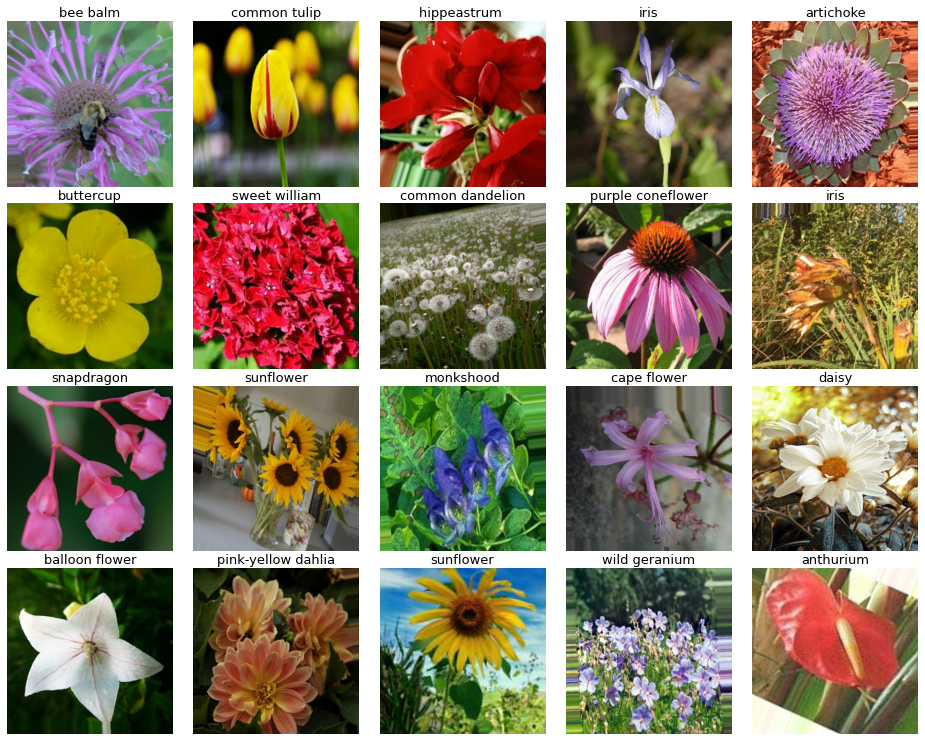

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 16, 16, 1920)      18321984  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 104)               199784    
Total params: 18,521,768
Trainable params: 199,784
Non-trainable params: 18,321,984
_________________________________________________________________

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/30
99/99 [==============================] - 57s 577ms/step - sparse_categorical_accuracy: 0.0703 - loss: 4.2606 - val_sparse_categorical_accuracy: 0.1037 - val_loss: 3.9975 - lr: 1.0000e-04

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00016.
Epoch 2/30
99/99 [=========

KeyboardInterrupt: 

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Running on TPU : ",tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS : ",strategy.num_replicas_in_sync)

from kaggle_datasets import KaggleDatasets
GCS_DS_PATH = KaggleDatasets().get_gcs_path('flower-classification-with-tpus')

GCS_PATH = GCS_DS_PATH + '/tfrecords-jpeg-512x512'
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec')

IMAGE_SIZE = [512, 512]
EPOCHS = 30
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

AUTO = tf.data.experimental.AUTOTUNE

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0 
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum

def load_dataset(filenames, labeled = True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    return dataset

def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.map(transform, num_parallel_calls=AUTO)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

import re
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

ds_train = get_training_dataset()
ds_valid = get_validation_dataset()
ds_test = get_test_dataset()

print("Training:", ds_train)
print ("Validation:", ds_valid)
print("Test:", ds_test)

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']  

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

print("Number of classes: {}".format(len(CLASSES)))
print("First five classes, sorted alphabetically:")
for name in sorted(CLASSES)[:5]:
    print(name)
print ("Number of training images: {}".format(NUM_TRAINING_IMAGES))

print("Training data shapes:")
for image, label in ds_train.take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())

print("Test data shapes:")
for image, idnum in ds_test.take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object:
        numpy_labels = [None for _ in enumerate(numpy_images)]
    return numpy_images, numpy_labels

def display_batch_of_images(databatch, predictions=None):
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()
    
import math
import matplotlib.pyplot as plt
one_batch = next(iter(ds_train.unbatch().batch(20)))
display_batch_of_images(one_batch)






In [9]:
with strategy.scope():
    pretrained_model = tf.keras.applications.DenseNet201(
        weights = 'imagenet',
        include_top = False,
        input_shape = [*IMAGE_SIZE,3]
    )
    pretrained_model.trainable = True
    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES),activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics = ['sparse_categorical_accuracy']
    )
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 16, 16, 1920)      18321984  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1920)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 104)               199784    
Total params: 18,521,768
Trainable params: 18,292,712
Non-trainable params: 229,056
_________________________________________________________________


In [10]:
#Learning rate scheduler
LR_START = 0.001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

In [11]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
EPOCHS = 15
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
history = model.fit(
    ds_train,
    validation_data = ds_valid,
    epochs = EPOCHS,
    callbacks = [lr_callback],
    steps_per_epoch = STEPS_PER_EPOCH
)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/15
99/99 [==============================] - 92s 934ms/step - sparse_categorical_accuracy: 0.6189 - loss: 1.6236 - val_sparse_categorical_accuracy: 0.1215 - val_loss: 7.0686 - lr: 0.0010

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00088.
Epoch 2/15
99/99 [==============================] - 60s 609ms/step - sparse_categorical_accuracy: 0.8358 - loss: 0.6498 - val_sparse_categorical_accuracy: 0.4324 - val_loss: 2.3140 - lr: 8.8000e-04

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00076.
Epoch 3/15
99/99 [==============================] - 61s 619ms/step - sparse_categorical_accuracy: 0.8988 - loss: 0.4015 - val_sparse_categorical_accuracy: 0.8068 - val_loss: 0.7491 - lr: 7.6000e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0006399999999999999.
Epoch 4/15
99/99 [==============================] - 61s 615ms/step - sparse_categorical_accuracy: 0.9301 - loss: 0

KeyboardInterrupt: 

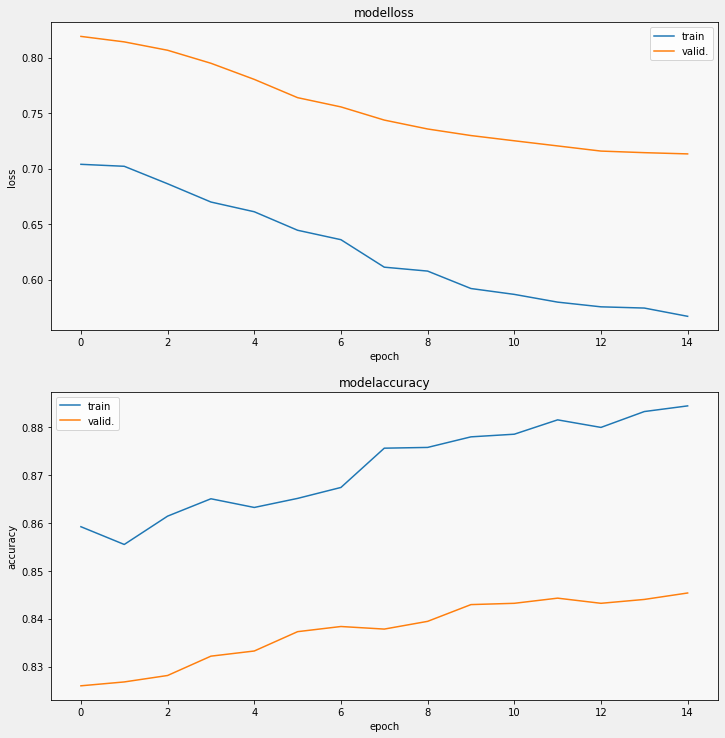

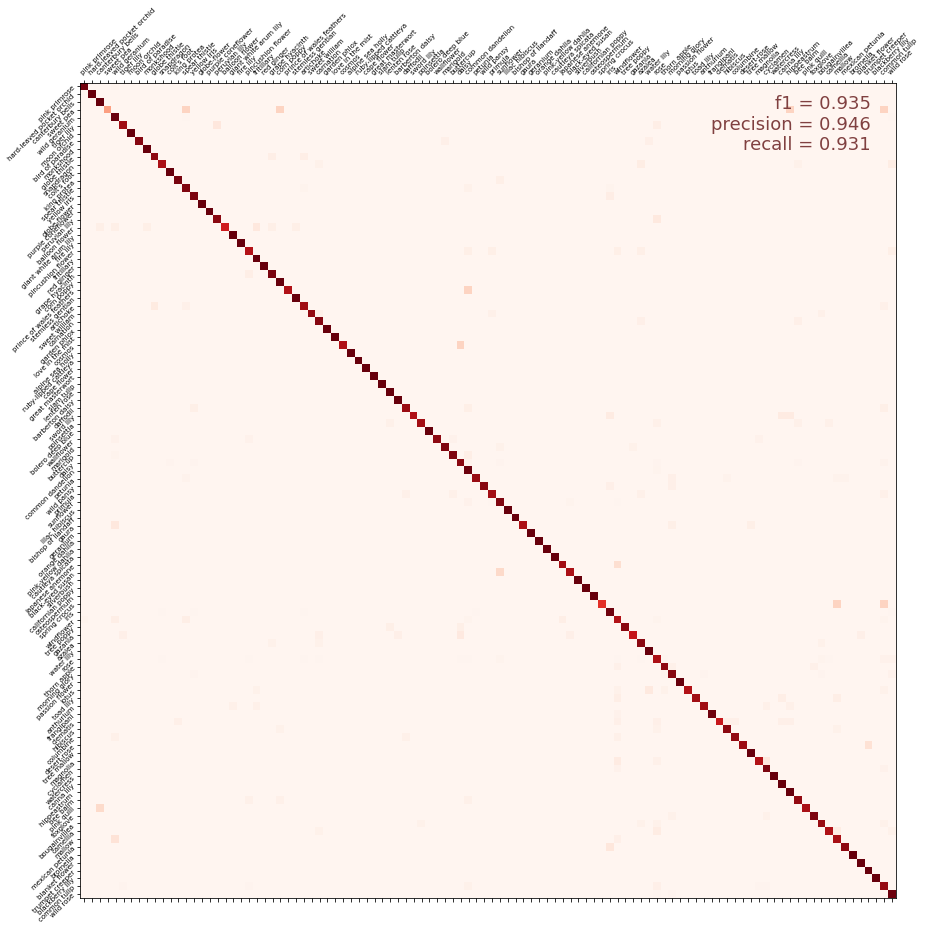

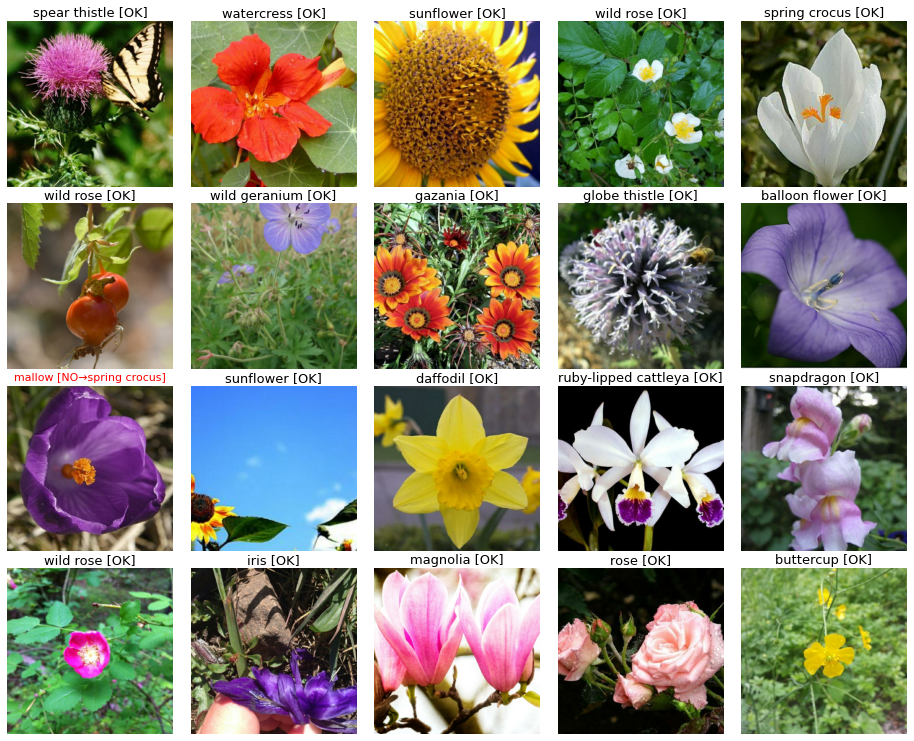

Computing Predictions...
[ 67  28  83 ... 103 102  62]
Generating Submission.csv file
id,label
252d840db,67
1c4736dea,28
c37a6f3e9,83
00e4f514e,103
59d1b6146,46
8d808a07b,53
aeb67eefb,52
53cfc6586,29
aaa580243,82


In [12]:
def display_training_curve(training, validation, title, subplot):
    if subplot%10 == 1:
        plt.subplots(figsize = (10,10), facecolor="#F0F0F0")
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor("#F8F8F8")
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model'+title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train','valid.'])

display_training_curve(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211
)
display_training_curve(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212
)

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
cmdataset = get_validation_dataset(ordered=True)
image_ds = cmdataset.map(lambda image, label : image)
label_ds = cmdataset.map(lambda image, label : label).unbatch()
cm_correct_labels = next(iter(label_ds.batch(NUM_VALIDATION_IMAGES))).numpy()
cm_probabilities = model.predict(image_ds)
cm_predictions = np.argmax(cm_probabilities, axis=-1)
labels = range(len(CLASSES))
cmat = confusion_matrix(
    cm_correct_labels,
    cm_predictions,
    labels = labels
)

cmat = (cmat.T / cmat.sum(axis=1)).T

score = f1_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro'
)
precision_score = precision_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro'
)
recall_score = recall_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro'
)

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat,cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize':7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha='left', rotation_mode='anchor')
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize':7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
display_confusion_matrix(cmat,score,precision_score, recall_score)

dataset = get_validation_dataset()
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)

image, labels = next(batch)
probabilities = model.predict(image)
predictions = np.argmax(probabilities,axis=-1)

display_batch_of_images((image, labels), predictions)

test_ds = get_test_dataset(ordered=True)
print('Computing Predictions...')
test_image_ds = test_ds.map(lambda image, idnum: image)
prob = model.predict(test_image_ds)
pred = np.argmax(prob,axis=-1)
print(pred)

print("Generating Submission.csv file")
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')
np.savetxt(
    'submission.csv',
    np.rec.fromarrays([test_ids, pred]),
    fmt=['%s', '%d'],
    delimiter=',',
    header='id,label',
    comments='',
)
!head submission.csv